# Extra IPython Features Analyses

This notebooks has extra analyses related to IPython Features. These analyses did not make into the paper.

In [1]:
import sys
sys.path.insert(0, '../archaeology')

from collections import Counter
from pprint import pprint

import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3

from db import connect, Query
import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import display_counts, violinplot, fig
from analysis_helpers import calculate_auto, close_fig

%matplotlib inline

## Query

Select features from:

- existing
  
  ```n.skip & 2048 = 0```


- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```


- python notebooks
  
  ```n.language = 'python'```


- with valid syntax
  
  ```n.processed & 16 = 0
  AND LEFT(n.language_version, 1) IN ('2', '3')```

In [2]:
%%time

with connect() as session:
    features = pd.read_sql("""
        SELECT f.*
        FROM notebooks n, notebook_features f
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.language = 'python'
        AND n.processed & 16 = 0
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND f.notebook_id = n.id
    """, session.connection())
    print("Valid Python notebooks:", len(features))


Valid Python notebooks: 886668
CPU times: user 6.57 s, sys: 389 ms, total: 6.95 s
Wall time: 11.6 s


In [3]:
columns = [
    "shadown_ref", "output_ref", "system",
    "set_next_input", "input_ref", "magic",
    "run_line_magic", "run_cell_magic", 
    "getoutput", "set_hook"
]
count_columns = [c + "_count" for c in columns]
for column in columns:
    features[column] = features[column].apply(lambda c: set(c.split(",")))

In [4]:
features.head(5)

,id,repository_id,notebook_id,index,index_count,any,any_count,shadown_ref,shadown_ref_count,output_ref,...,run_line_magic,run_line_magic_count,run_cell_magic,run_cell_magic_count,getoutput,getoutput_count,set_hook,set_hook_count,others,skip
0,84528,87859,578955,,0,,0,{},0,{},...,{},0,{},0,{},0,{},0,,0
1,732536,69785,482136,,0,,0,{},0,{},...,{},0,{},0,{},0,{},0,,0
2,1033342,220892,1253631,,0,,0,{},0,{},...,{},0,{},0,{},0,{},0,,0
3,272782,5882,82977,,0,,0,{},0,{},...,{},0,{},0,{},0,{},0,,0
4,588971,223497,1267215,,0,,0,{},0,{},...,{},0,{},0,{},0,{},0,,32


## Features


Currently, we only have IPython features

* IPython/magic: `%example`
* IPython/run_line_magic: `%example`
* IPython/output_ref: `_2`, `Out[3]`
* IPython/run_cell_magic: `%%timeit`
* IPython/system: `!ls`
* IPython/getoutput: `x = !ls`
* IPython/input_ref: `In[2]`
* IPython/set_next_input: `a = x??`

* IPython/shadown_ref: `_sh`


False positives


* IPython/set_hook: `get_ipython().set_hook()`


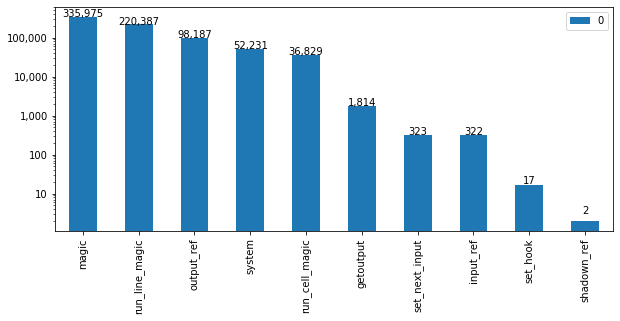

,0
magic,335975
run_line_magic,220387
output_ref,98187
system,52231
run_cell_magic,36829
getoutput,1814
set_next_input,323
input_ref,322
set_hook,17
shadown_ref,2


In [5]:
count = features[count_columns].sum().rename(
    lambda x: x[:-6]
).sort_values(ascending=False)
display_counts(count, width=10, show_values=True)

### magic

`%matplotlib inline`

,0
matplotlib,231058
load_ext,21286
pylab,20400
autoreload,16712
time,7670
config,7163
pinfo,5540
run,4388
timeit,3962
reload_ext,1731


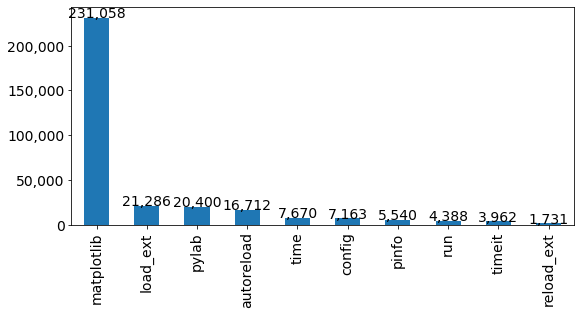

In [6]:
counter = Counter()
features["magic"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_magic", 9, 4):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

### run_line_magic

`%matplotlib inline`

,0
matplotlib,156353
load_ext,14216
autoreload,12920
pylab,8183
time,5172
config,4805
pinfo,3263
run,2474
timeit,2318
reload_ext,1635


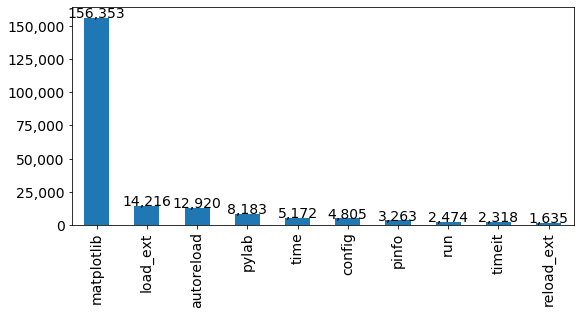

In [7]:
counter = Counter()
features["run_line_magic"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_run_line_magic", 9, 4):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

### magic + run_line_magic

`%matplotlib inline`

,0
matplotlib,387373
load_ext,35502
autoreload,29632
pylab,28579
time,12842
config,11968
pinfo,8803
run,6862
timeit,6280
reload_ext,3366


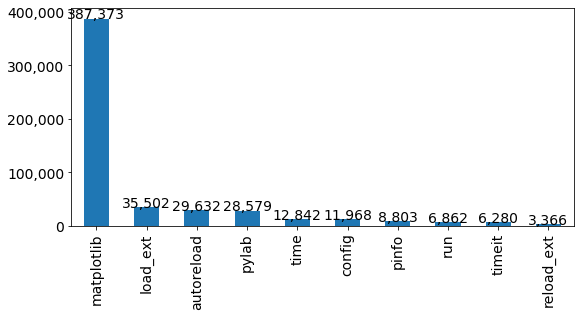

In [8]:
counter = Counter()
np.bitwise_or(features["magic"], features["run_line_magic"]).agg(
    lambda x: counter.update(x)
).agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_line_magic", 9, 4):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

In [9]:
print("% of notebooks with matplotlib magic: {:.2%}".format(counter["matplotlib"] / len(features)))
five_percent = 0.05 * len(features)
if all(
    v < five_percent for k, v in counter.items()
    if k != "matplotlib"
):
    print("All other magics appear in less than 5% of the notebooks")
else:
    print("ToDo: Recheck 5%")


% of notebooks with matplotlib magic: 43.69%
All other magics appear in less than 5% of the notebooks


### output_ref

`x = _`

,0
_,96677
__,678
___,111
Out[],103
_2,100
_1,96
_3,41
_4,24
_5,22
_6,19


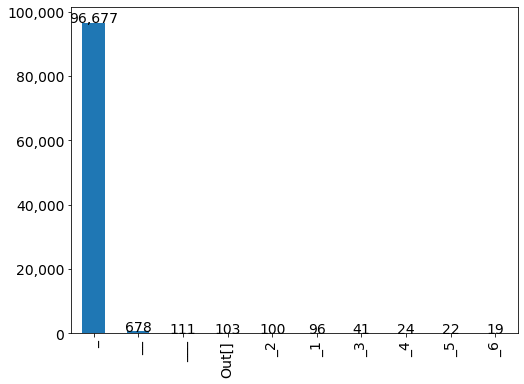

In [10]:
counter = Counter()
features["output_ref"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_output_ref", 8, 6):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

### run_cell_magic

`
%%time
2**1000000
`

,0
time,13129
writefile,2937
bash,2850
timeit,2628
javascript,2447
sql,1822
HTML,1501
html,1443
R,1295
capture,1131


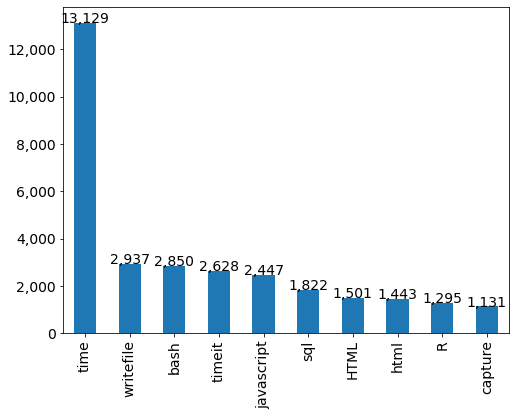

In [11]:
counter = Counter()
features["run_cell_magic"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_run_cell_magic", 8, 6):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)


### system

`!ls`

,0
ls,5503
pip,5500
cat,2989
head,2926
rm,2628
mkdir,2545
wget,2194
python,2099
pwd,1424
curl,1156


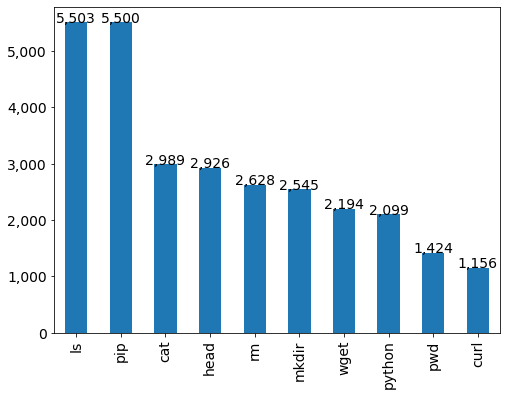

In [12]:
counter = Counter()
features["system"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_system", 8, 6):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

### getoutput

`x = !ls`

,0
ls,661
cat,114
pwd,96
find,76
wc,69
echo,50
grep,38
date,27
tail,24
dir,23


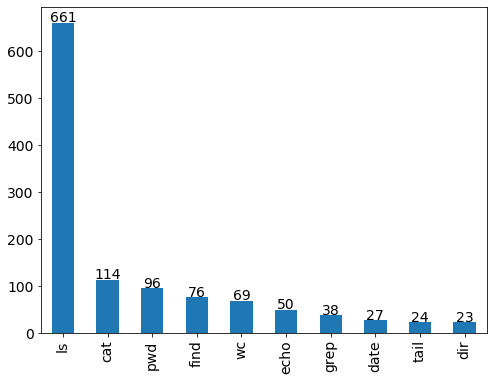

In [13]:
counter = Counter()
features["getoutput"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_getoutput", 8, 6):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

### system + getoutput by notebook

,0
ls,5975
pip,5513
cat,3087
head,2937
rm,2632
mkdir,2550
wget,2200
python,2115
pwd,1511
curl,1171


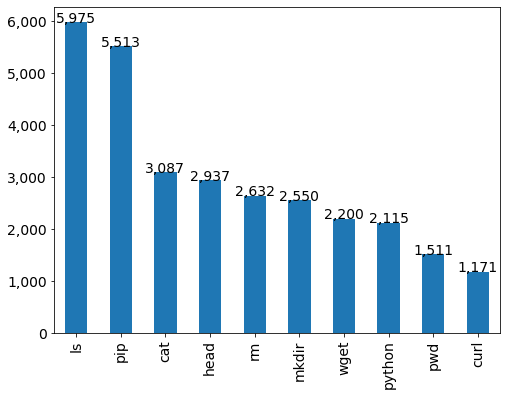

In [14]:
counter = Counter()
np.bitwise_or(features["system"], features["getoutput"]).agg(
    lambda x: counter.update(x)
)
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_bang", 8, 6):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

### input_ref

`x = _i`

,0
_i,204
In[],79
_ii,7
_i2,6
_iii,6
_i1,5
_ih[],2
_i3,2
_i7,2
_i6,1


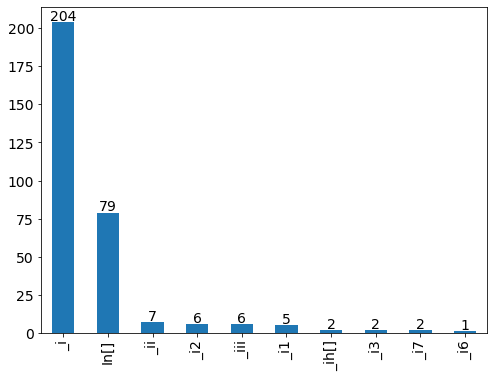

In [15]:
counter = Counter()
features["input_ref"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_input_ref", 8, 6):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)


### set_next_input

Help, when the line contains more than the help expression

`a = x??`

,0
print,15
df,14
data,12
a,7
x,7
b,5
What,5
iris,4
Y,3
y,3


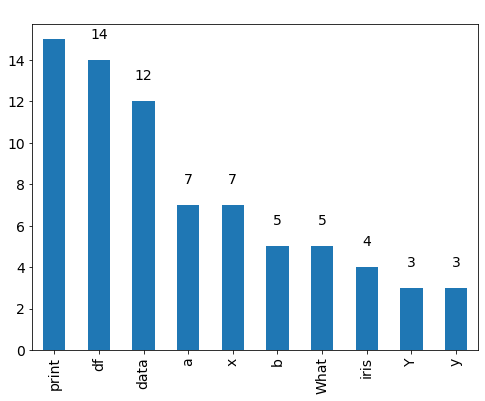

In [16]:
counter = Counter()
features["set_next_input"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_set_next_input", 8, 6):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)


### set_hook

False positive <br>
`get_ipython().set_hook()`

,0
show_in_pager,17


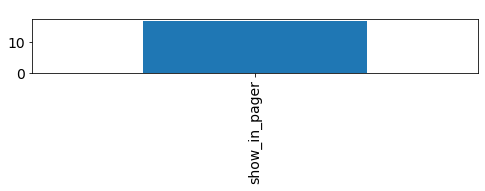

In [17]:
counter = Counter()
features["set_hook"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_set_hook", 8, 1):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

### shadown_ref

`_sh`

,0
_sh,2


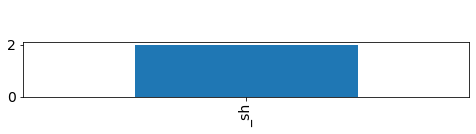

In [18]:
counter = Counter()
features["shadown_ref"].agg(lambda x: counter.update(x))
del counter['']
counts = pd.Series(counter).sort_values(ascending=False)
with fig("e7_notebook_feature_shadown_ref", 8, 1):
    gcf, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False)

This notebook analyzed the IPython features, but we did not include any of them in the paper